In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
#import seaborn as sns
from hmmlearn.hmm import GMMHMM
from tqdm import tqdm

In [3]:
pca = pd.read_csv("../../data/pca_5c.csv",index_col=0)
pca.index = pd.to_datetime(pca.index)
pca = pca.sort_index()

In [4]:
pca_new = pca.iloc[::-1]
pca_new['contago_next'] = pca_new['contago'].shift(-1)
pca_new['status_change'] = np.where(pca_new['contago'] != pca_new['contago_next'], 1,0)

/var/folders/mt/bm2h50kj2872xhymzl24djch0000gn/T/ipykernel_1025/2558895911.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pca_new['contago_next'] = pca_new['contago'].shift(-1)
/var/folders/mt/bm2h50kj2872xhymzl24djch0000gn/T/ipykernel_1025/2558895911.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pca_new['status_change'] = np.where(pca_new['contago'] != pca_new['contago_next'], 1,0)


In [5]:
ts = pca_new.iloc[np.where(pca_new['status_change'] == 1)].index
ts_2010 = ts[ts>'2010']

In [6]:
X = pca[["pca_0","pca_1"]]

In [7]:
def train_hmm(data):
    hmm = GMMHMM(n_components=2,n_mix = 3, covariance_type="full")
    hmm.fit(data);
    return hmm

def best_model(data,n=5):
    hmm_list = [train_hmm(data) for i in range(n)]
    aic_list=[model.aic(data) for model in hmm_list]
    return hmm_list[np.argmin(aic_list)]

def sum_off_diagonal(A):
    return np.sum(A)- np.trace(A)

In [44]:
result_5 = []
result_10 = []
for t in tqdm(X[X.index>"2010"].index):
    Xt= X[X.index<=t]
    try:
        hmm_model = best_model(Xt)
    #get result
        A_10 = np.linalg.matrix_power(hmm_model.transmat_,10)
        A_5 = np.linalg.matrix_power(hmm_model.transmat_,5)
        result_5.append(np.sum(A_5)- np.trace(A_5))
        result_10.append(np.sum(A_10)- np.trace(A_10))
    except:
        result_5.append(np.nan)
        result_10.append(np.nan)
        print (t)


 45%|████████████████████████████████████████████████████████████▍                                                                         | 1546/3428 [17:22<24:35,  1.28it/s]

2015-12-28 00:00:00


 49%|█████████████████████████████████████████████████████████████████▍                                                                    | 1675/3428 [19:05<23:28,  1.24it/s]/opt/anaconda3/envs/data_check/lib/python3.8/site-packages/hmmlearn/hmm.py:791: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
 49%|█████████████████████████████████████████████████████████████████▌                                                                    | 1676/3428 [19:05<20:31,  1.42it/s]

2016-06-29 00:00:00


 67%|█████████████████████████████████████████████████████████████████████████████████████████▋                                            | 2293/3428 [27:46<16:12,  1.17it/s]Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #2 has a null eigenvalue.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3428/3428 [47:23<00:00,  1.21it/s]


In [45]:
result_df = pd.DataFrame(list(zip(result_5, result_10)), index = X[X.index>"2010"].index,columns =['result_5','result_10'])

(array([13879., 14610., 15340., 16071., 16801., 17532., 18262., 18993.,
        19723.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

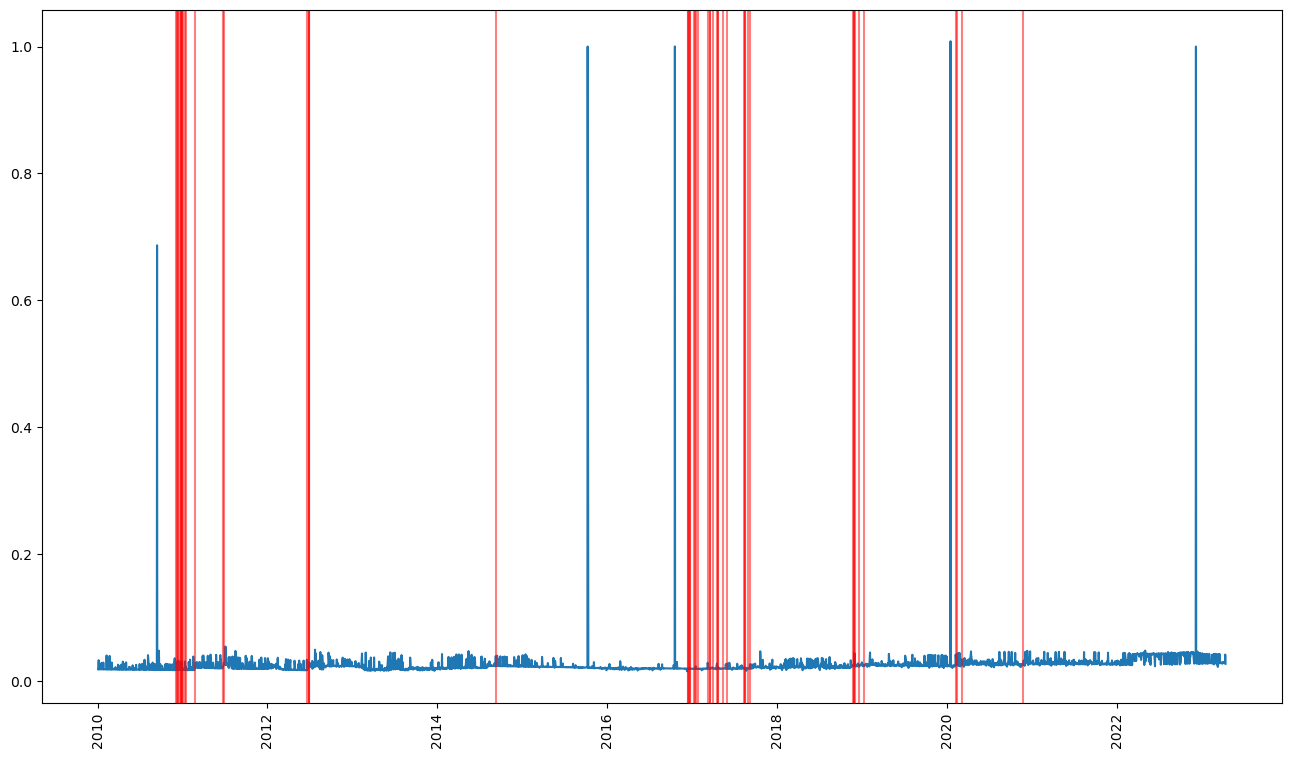

In [49]:
fig,ax=plt.subplots(1,1,figsize=(16,9))
plt.plot(result_df['result_5'],label="5 day trans")
#plt.plot(result_df['result_10'],label="10 day trans")
for i in ts_2010:
    ax.axvline(i,color="red",alpha=0.5)
plt.xticks(rotation='vertical')

In [50]:
import seaborn as sns

In [58]:
result_df1 = result_df.merge(pca_new,left_index=True,right_index=True)

In [97]:
result_df1["result_10_ma"] = result_df1["result_10"].rolling(5).mean()

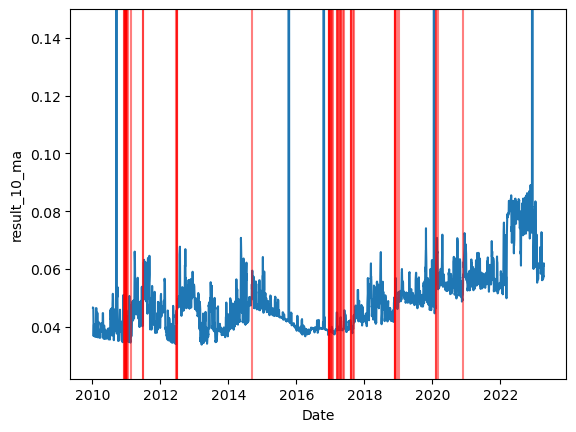

In [101]:
ax = sns.lineplot(data=result_df1.reset_index(),x="Date", y="result_10_ma")
ax.set_ylim(top=0.15)
for i in ts_2010:
    ax.axvline(i,color="red",alpha=0.5)

In [102]:
result_df1.to_csv("../../data/hmm_result_transition_prob.csv")

In [84]:
def moving_average(x, n):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[n:] - cumsum[:-n]) / float(n)

In [90]:
ax[0]

In [96]:
moving_average(result_df1["result_10"], 5)

array([0.04657709, 0.04655876, 0.04598968, ...,        nan,        nan,
              nan])

In [95]:
result_df1["result_10_ma"] = [np.nan]*4 + moving_average(result_df1["result_10"], 5)

ValueError: operands could not be broadcast together with shapes (4,) (3424,) 

AttributeError: 'Line2D' object has no attribute 'axvline'

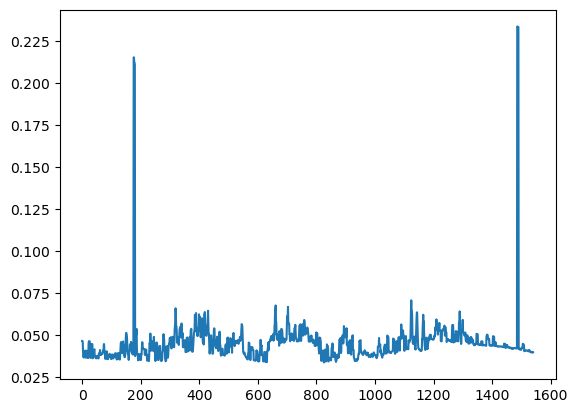

In [92]:
ax = plt.plot(moving_average(result_df1["result_10"], 5))
for i in ts_2010:
    ax[0].axvline(i,color="red",alpha=0.5)